In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import glob

import spam.DIC
import spam
import spam.plotting

from skimage.io import imread_collection
from skimage import morphology, measure

import pyvista as pv
import gmsh
import meshio
from natsort import os_sorted

from ipywidgets import interact, FloatSlider, IntSlider

plt.rcParams['font.size'] = 12

In [51]:
# Downloading the sample tomography
url = 'https://zenodo.org/record/7969434/files/CAC_sample.npz'
os.system(f'wget -c --read-timeout=5 --tries=0 "{url}"');

--2023-05-25 10:05:58--  https://zenodo.org/record/7969434/files/CAC_sample.npz
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96000262 (92M) [application/octet-stream]
Saving to: ‘CAC_sample.npz’

     0K .......... .......... .......... .......... ..........  0% 7.62M 12s
    50K .......... .......... .......... .......... ..........  0% 7.31M 12s
   100K .......... .......... .......... .......... ..........  0% 7.85M 12s
   150K .......... .......... .......... .......... ..........  0% 5.73M 13s
   200K .......... .......... .......... .......... ..........  0% 9.97M 12s
   250K .......... .......... .......... .......... ..........  0% 6.34M 13s
   300K .......... .......... .......... .......... ..........  0% 12.0M 12s
   350K .......... .......... .......... .......... ..........  0% 5.68M 12s
   400K .......... .......... .......... .......... ..

In [55]:
# Create folder for meshes
dir_output = './meshes'
if not os.path.exists(dir_output):
    os.mkdir(dir_output)

# Loading Tomography

In [52]:
whole_tomo = np.load('./CAC_sample.npz')['data']
n_vox_x, n_vox_y, n_vox_z = whole_tomo.shape
print(f'Voxels in x-direction (whole tomography): {n_vox_x}')
print(f'Voxels in y-direction (whole tomography): {n_vox_y}')
print(f'Voxels in z-direction (whole tomography): {n_vox_z}')

Voxels in x-direction (whole tomography): 300
Voxels in y-direction (whole tomography): 200
Voxels in z-direction (whole tomography): 200


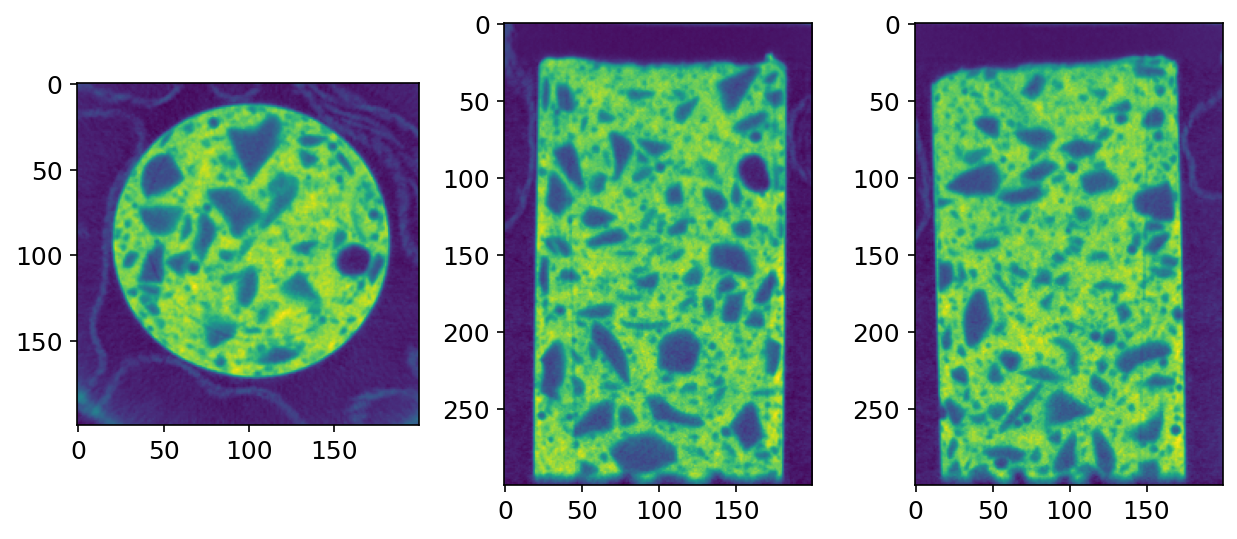

In [53]:
# First look at tomography image
fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

axs[0].imshow(whole_tomo[n_vox_z//2, :, :])
axs[1].imshow(whole_tomo[:, n_vox_y//2, :])
axs[2].imshow(whole_tomo[:, :, n_vox_z//2])

plt.show()

# Cropping and masking the sample

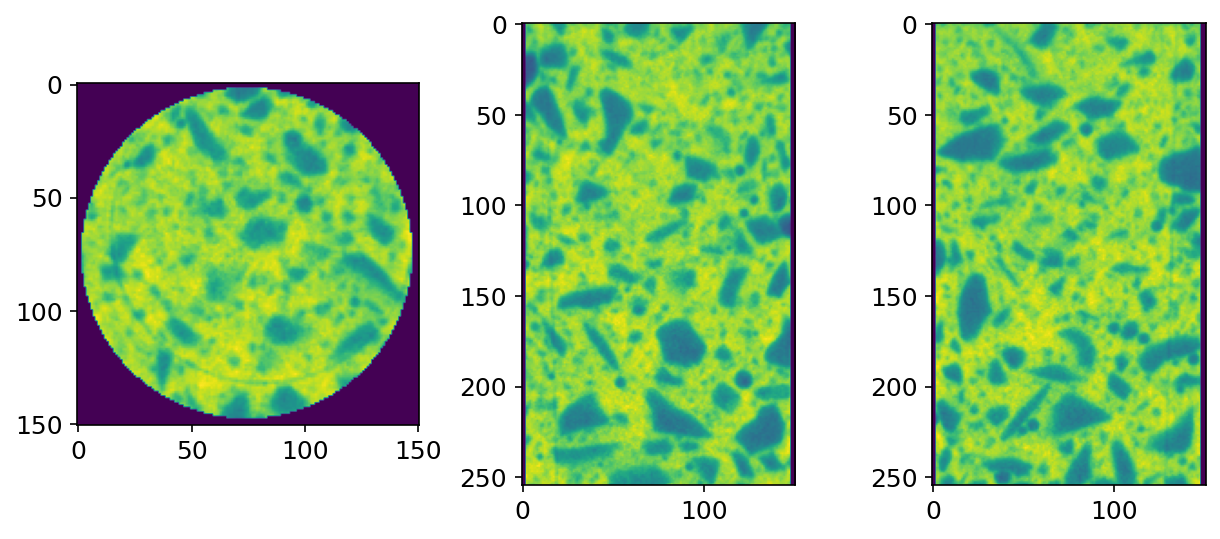

In [4]:
# Cropping and adding a cylinder mask on the tomography to retrieve the sample only

fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

whole_tomo_crop = whole_tomo[35:290, 17:168, 26:177]


cylinder_mask = spam.mesh.createCylindricalMask(whole_tomo_crop.shape, 73, centre=[75, 75])
sample = cylinder_mask * whole_tomo_crop


axs[0].imshow(sample[sample.shape[0]//2, :, :])
axs[1].imshow(sample[:, sample.shape[1]//2, :])
axs[2].imshow(sample[:, :, sample.shape[2]//2])

plt.show()

In [5]:
n_vox_x, n_vox_y, n_vox_z = sample.shape
print(f'Voxels in x-direction (cropped): {n_vox_x}')
print(f'Voxels in y-direction (cropped): {n_vox_y}')
print(f'Voxels in z-direction (cropped): {n_vox_z}')

Voxels in x-direction (cropped): 255
Voxels in y-direction (cropped): 151
Voxels in z-direction (cropped): 151


# Thresholding the aggregates

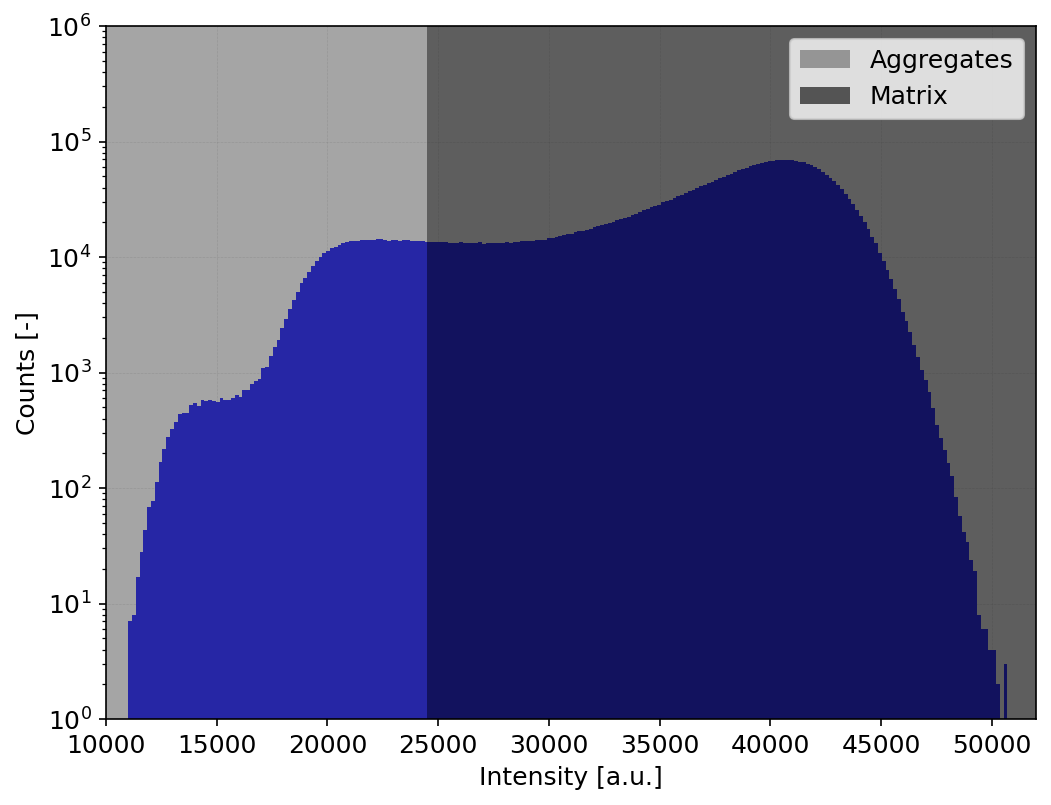

In [6]:
# Thresholding the aggregates

fig, ax = plt.subplots(1, 1, figsize=(8, 6), dpi=150)

plt.hist(sample.flatten(), 300, zorder=2, color='blue')

plt.xlim(1e4, 5.2e4)
plt.ylim(1e0, 1e6)

x0 = 1e4
aggs_lim = 2.45e4
aggs_zone = mpl.patches.Rectangle((x0, 0), aggs_lim - x0, 1e6,
                                   edgecolor=None, facecolor='0.3',
                                   alpha=0.5, zorder=2, label='Aggregates')

matrix_zone = mpl.patches.Rectangle((aggs_lim, 0), 5.2e4 - aggs_lim, 1e6,
                                   edgecolor=None, facecolor='0.1',
                                   alpha=0.7, zorder=2, label='Matrix')

ax.add_patch(aggs_zone)
ax.add_patch(matrix_zone)

ax.set_yscale('log')

plt.ylabel('Counts [-]')
plt.xlabel('Intensity [a.u.]')

plt.legend()
plt.grid(ls=':', lw=0.25, zorder=-1)
plt.show()

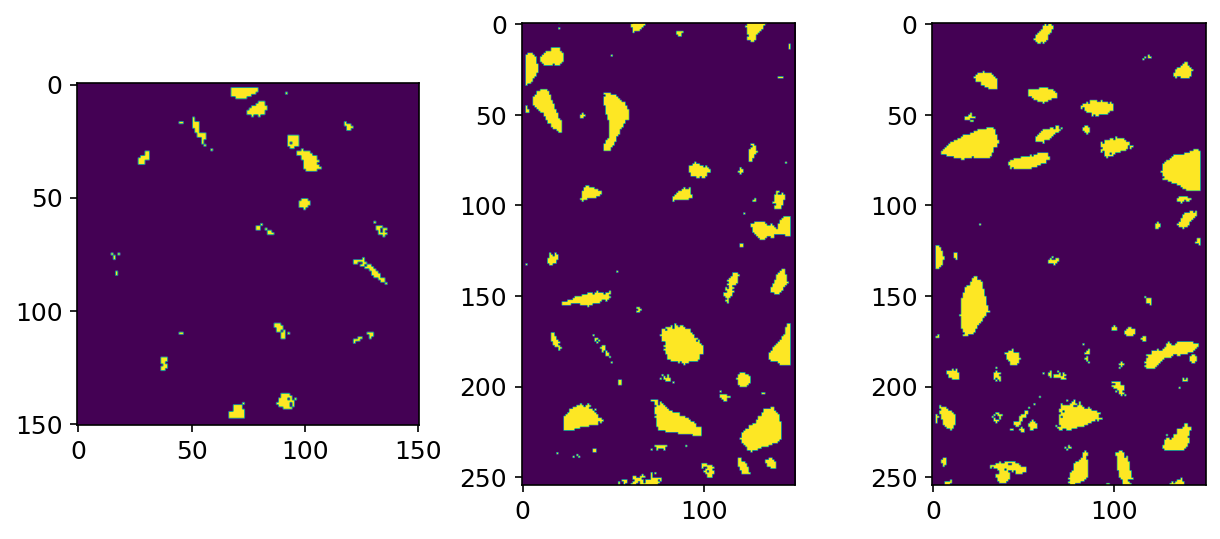

In [7]:
aggregates = (sample < aggs_lim) * cylinder_mask


fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

axs[0].imshow(aggregates[aggregates.shape[0]//2, :, :])
axs[1].imshow(aggregates[:, aggregates.shape[1]//2, :])
axs[2].imshow(aggregates[:, :, aggregates.shape[2]//2])

plt.show()

# Sieving Smaller Aggregates

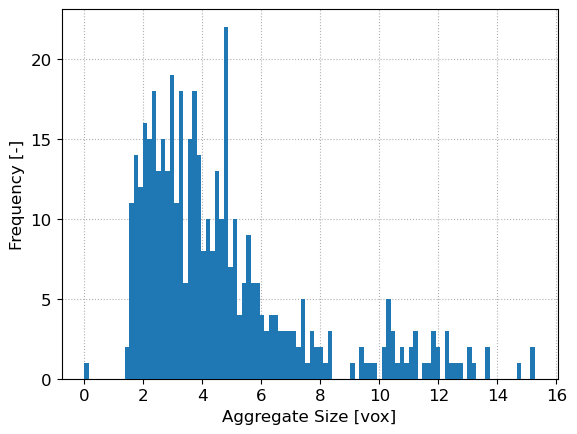

In [8]:
# Applying the watershed algorithm to separate the aggregates
binary_labels_spam = spam.label.watershed(aggregates)

# Getting the equivalent radii of each aggregate
radii = spam.label.equivalentRadii(binary_labels_spam)
radii_sieved = np.copy(radii)
radii_sieved[radii_sieved<10] = 0

plt.hist(radii, 100, zorder=3)
plt.xlabel('Aggregate Size [vox]')
plt.ylabel('Frequency [-]')
plt.grid(ls=':')
plt.show()

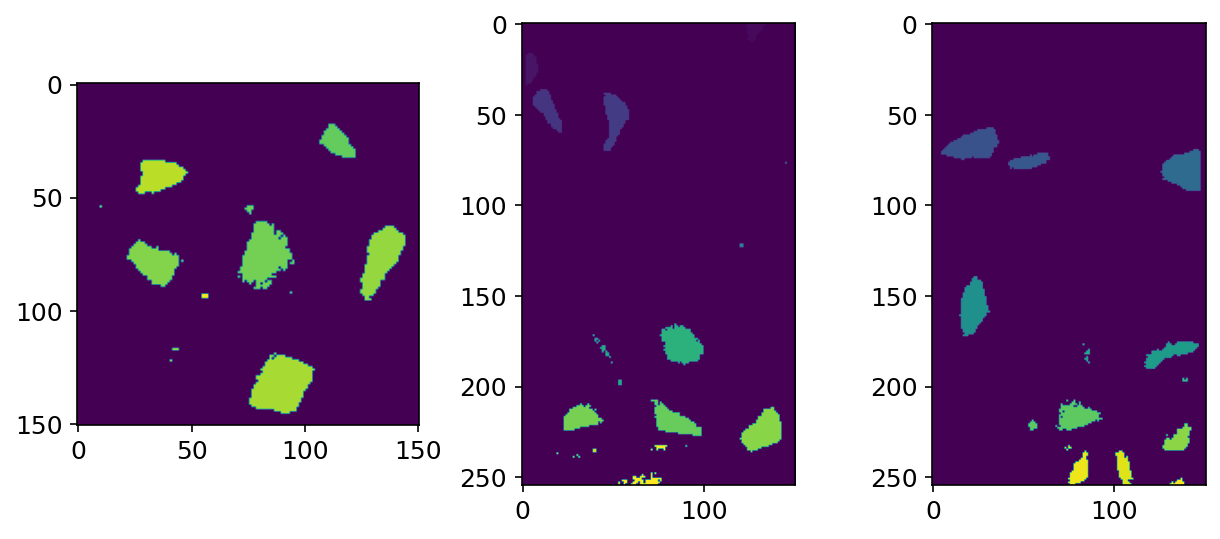

In [9]:
# Create the image with each aggregate labelled
spam_sieved = spam.label.convertLabelToFloat(binary_labels_spam, radii_sieved)

# Get new labels for sieved aggregates
spam_sieved_labels = spam.label.watershed(spam_sieved)

fig, axs = plt.subplots(1, 3, figsize=(10, 4), dpi=150)

axs[0].imshow(spam_sieved_labels[220, :, :])
axs[1].imshow(spam_sieved_labels[:, spam_sieved_labels.shape[1]//2, :])
axs[2].imshow(spam_sieved_labels[:, :, spam_sieved_labels.shape[2]//2])

plt.show()

In [10]:
# Converting the np.array image to a pyvista Uniform Grid
pv_sieved = pv.UniformGrid(dimensions=[255, 151, 151],
               spacing=[160e-6, 160e-6, 160e-6], 
               origin=[0, 0, 0])
pv_sieved.point_data['Label'] = spam_sieved_labels.T.flatten()
agg_flag = np.zeros(spam_sieved_labels.T.shape).flatten()
agg_flag[spam_sieved_labels.T.flatten()!=0] = 1
pv_sieved.point_data['Aggs'] = agg_flag
pv_sieved

UniformGrid (0x7f5d61b2e600)
  N Cells:      5715000
  N Points:     5814255
  X Bounds:     0.000e+00, 4.064e-02
  Y Bounds:     0.000e+00, 2.400e-02
  Z Bounds:     0.000e+00, 2.400e-02
  Dimensions:   255, 151, 151
  Spacing:      1.600e-04, 1.600e-04, 1.600e-04
  N Arrays:     2

In [11]:
# Saving the aggregates to a vtk file
pv_sieved.save('./meshes/0_tomo.vtk')

In [13]:
# Performing erosion and dilation

pv_sieved_e_d = pv_sieved.copy()

n_ero_dil = 2
ks = 4
for i in range(n_ero_dil):
    for j in range(0, 40):
        pv_sieved_e_d = pv_sieved_e_d.image_dilate_erode(dilate_value=0, erode_value=j, kernel_size=(ks, ks, ks))
    
for i in range(n_ero_dil + 1):
    for j in range(0, 40):
        pv_sieved_e_d = pv_sieved_e_d.image_dilate_erode(dilate_value=j, erode_value=0, kernel_size=(ks, ks, ks))
    

In [14]:
# Saving the result to a vtk file
pv_sieved_e_d.save('./meshes/1_tomo_e_d.vtk')

# Create Raw Surface Mesh 

In [15]:
# Creating a common flag for all aggregates to perform the surface meshing
agg_flag_e_d = np.zeros(spam_sieved_labels.T.shape).flatten()
agg_flag_e_d[pv_sieved_e_d.point_data['Label'] != 0] = 1
pv_sieved.point_data['Aggs_e_d'] = agg_flag_e_d

# Applying the marching cubes algorithm
contour = pv_sieved_e_d.contour([1], scalars='Label', method='marching_cubes')

# Saving the result to a vtk file
contour.save('./meshes/2_contour_raw_mesh.vtk')

In [26]:
# Creating the raw surface mesh
surf_raw_mesh = contour.extract_geometry()

# Filling the smaller holes using pyvista method
surf_raw_mesh.fill_holes(5, inplace=True)

# Using the clean functionality to remove degenerate surfaces etc
surf_raw_mesh.clean(inplace=True)

PolyData (0x7f5d61330670)
  N Cells:    268880
  N Points:   134524
  N Strips:   0
  X Bounds:   0.000e+00, 4.064e-02
  Y Bounds:   1.296e-03, 2.400e-02
  Z Bounds:   4.000e-04, 2.399e-02
  N Arrays:   1

In [24]:
# Use pymeshfix to fix the larger holes

from pymeshfix._meshfix import PyTMesh
mfix = PyTMesh(False)  # False removes extra verbose output
mfix.load_array(surf_raw_mesh.points, surf_raw_mesh.faces.reshape((surf_raw_mesh.n_faces, 4))[:, 1:] )

# Fills all the holes having at at most 'nbe' boundary edges. If
# 'refine' is true, adds inner vertices to reproduce the sampling
# density of the surroundings. Returns number of holes patched.  If
# 'nbe' is 0 (default), all the holes are patched.
mfix.fill_small_boundaries(refine=True)

0

In [27]:
# Converting the pymeshfix object to pyvista polydata
vert, faces = mfix.return_arrays()
triangles = np.empty((faces.shape[0], 4), dtype=faces.dtype)
triangles[:, -3:] = faces
triangles[:, 0] = 3

surf_raw_mesh = pv.PolyData(vert, triangles)

In [28]:
# Splitting the aggregates
aggs_raw = surf_raw_mesh.split_bodies(label=True)
sieved_aggs = []

# Performing the sieving based on the surface area of the aggregates
for agg in aggs_raw:
    if agg.area > 1e-5:
        sieved_aggs.append(agg)
        
sieved_aggs_raw = pv.MultiBlock(sieved_aggs)

In [ ]:
# Performing smoothing of the aggregates and saving each one in an individual stl
for i, sie_agg in enumerate(sieved_aggs):
    print(f'Getting Mesh for Agg: {i+1}')
    sie_agg_raw_surf = sie_agg.extract_geometry()
    sie_agg_smooth_surf = sie_agg_raw_surf.smooth_taubin(n_iter=100, pass_band=0.025 * 2, progress_bar=False)
    pv.save_meshio(f'./meshes/aggs/agg_{i+1}.stl', sie_agg_smooth_surf)

Getting Mesh for Agg: 1
Getting Mesh for Agg: 2
Getting Mesh for Agg: 3
Getting Mesh for Agg: 4
Getting Mesh for Agg: 5
Getting Mesh for Agg: 6
Getting Mesh for Agg: 7
Getting Mesh for Agg: 8
Getting Mesh for Agg: 9
Getting Mesh for Agg: 10
Getting Mesh for Agg: 11
Getting Mesh for Agg: 12
Getting Mesh for Agg: 13
Getting Mesh for Agg: 14
Getting Mesh for Agg: 15
Getting Mesh for Agg: 16
Getting Mesh for Agg: 17
Getting Mesh for Agg: 18
Getting Mesh for Agg: 19
Getting Mesh for Agg: 20
Getting Mesh for Agg: 21
Getting Mesh for Agg: 22
Getting Mesh for Agg: 23
Getting Mesh for Agg: 24
Getting Mesh for Agg: 25
Getting Mesh for Agg: 26
Getting Mesh for Agg: 27
Getting Mesh for Agg: 28
Getting Mesh for Agg: 29
Getting Mesh for Agg: 30
Getting Mesh for Agg: 31
Getting Mesh for Agg: 32
Getting Mesh for Agg: 33
Getting Mesh for Agg: 34
Getting Mesh for Agg: 35
Getting Mesh for Agg: 36
Getting Mesh for Agg: 37
Getting Mesh for Agg: 38
Getting Mesh for Agg: 39


In [34]:
# Saving it to a vtk file
sieved_aggs_raw_surf = sieved_aggs_raw.extract_geometry()
surf_smooth_mesh = sieved_aggs_raw_surf.smooth_taubin(n_iter=100, pass_band=0.025 * 2)
surf_smooth_mesh.save('./meshes/3_surf_smooth_mesh.vtk')

# Creating the Volume Mesh Using Gmsh

In [35]:
def group_surfaces_adjacencies(adj):
    '''
    Function to goup the surfaces adjacencies.
    Reference: https://stackoverflow.com/a/4842897
    '''
    l = adj
    out = []
    while len(l)>0:
        first, *rest = l
        first = set(first)

        lf = -1
        while len(first)>lf:
            lf = len(first)

            rest2 = []
            for r in rest:
                if len(first.intersection(set(r)))>0:
                    first |= set(r)
                else:
                    rest2.append(r)     
            rest = rest2

        out.append(list(first))
        l = rest
    return out

In [36]:
# Defining geometry dimensions
d = 3.3
r = 3.3 / 2
h = 5
r/100, h/100

(0.0165, 0.05)

In [37]:
gmsh.initialize()  # Initialize the gmsh API

# Merge each aggregate STL file
for i, agg_path in enumerate(os_sorted(glob.glob('./meshes/aggs/*'))):
    print(i)
    gmsh.merge(os.path.join(agg_path))

# Split each surfaces for creating the separated geometry entities
gmsh.model.mesh.classifySurfaces(gmsh.pi, True, True, gmsh.pi)


0
Info    : Reading './meshes/aggs/agg_1.stl'...
Info    : 3144 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_1.stl'
1
Info    : Reading './meshes/aggs/agg_2.stl'...
Info    : 8522 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_2.stl'
2
Info    : Reading './meshes/aggs/agg_3.stl'...
Info    : 9502 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_3.stl'
3
Info    : Reading './meshes/aggs/agg_4.stl'...
Info    : 9500 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_4.stl'
4
Info    : Reading './meshes/aggs/agg_5.stl'...
Info    : 5642 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_5.stl'
5
Info    : Reading './meshes/aggs/agg_6.stl'...
Info    : 4508 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_6.stl'
6
Info    : Reading './meshes/aggs/agg_7.stl'...
Info    : 7872 facets in solid 0 
Info    : Done reading './meshes/aggs/agg_7.stl'
7
Info    : Reading './meshes/aggs/agg_8.stl'...
Info    : 5142 facets in so

In [38]:
# Create a geometry for each one of the discrete entities (aggregates)
gmsh.model.mesh.createGeometry()

Info    : Creating geometry of discrete curves...
Info    : Done creating geometry of discrete curves (Wall 0.000433s, CPU 0.00125s)
Info    : Creating geometry of discrete surfaces...
Info    : Done creating geometry of discrete surfaces (Wall 2.73287s, CPU 2.74674s)


In [40]:
# As the gmsh `classifySurfaces()` function splits the aggregates
# surfaces into multiple parts (most of the time into two parts), retrieve 
# which surfaces are part of which aggregates through adjencies of the curves
surfaces_adjacencies = []
for i, entity in enumerate(gmsh.model.getEntities(1)):
    surfaces_adjacencies.append(gmsh.model.get_adjacencies(entity[0], entity[1])[0])

# Python function to group surfacs that share at least a single upward adjency
surfaces_to_combine = group_surfaces_adjacencies(surfaces_adjacencies)

In [41]:
# Create a list with the surface loops of each aggregate
agg_surf_loop_list = []
for i, stc in enumerate(surfaces_to_combine):
    agg_surf = gmsh.model.geo.addSurfaceLoop(stc)   # Add the surface loop
    agg_surf_loop_list.append(agg_surf)             # Include in the list
    gmsh.model.geo.addVolume([agg_surf], tag=i)     # Create the volume
    
# Save the last tag index for the aggregate
agg_last_idx = i

In [42]:
# Synchronize the built-in CAD representation with the current Gmsh model
gmsh.model.geo.synchronize()

In [43]:
# Create the cylinder that represents the sample's boundaries

r = 0.0124
h = 0.0435
x_offset = -0.002
gmsh.model.geo.add_point(x_offset, 0 + r, 0 + r, tag=int(1 + 1e6))
gmsh.model.geo.add_point(x_offset, r + r, 0 + r, tag=int(2 + 1e6))
gmsh.model.geo.add_point(x_offset, 0 + r, r + r, tag=int(3 + 1e6))
gmsh.model.geo.add_point(x_offset, -r + r, 0 + r, tag=int(4 + 1e6))
gmsh.model.geo.add_point(x_offset, 0 + r, -r + r, tag=int(5 + 1e6))

gmsh.model.geo.add_circle_arc(int(2 + 1e6), int(1 + 1e6), int(3 + 1e6), tag=int(1 + 1e6))
gmsh.model.geo.add_circle_arc(int(3 + 1e6), int(1 + 1e6), int(4 + 1e6), tag=int(2 + 1e6))
gmsh.model.geo.add_circle_arc(int(4 + 1e6), int(1 + 1e6), int(5 + 1e6), tag=int(3 + 1e6))
gmsh.model.geo.add_circle_arc(int(5 + 1e6), int(1 + 1e6), int(2 + 1e6), tag=int(4 + 1e6))

gmsh.model.geo.add_curve_loop([int(1 + 1e6), int(2 + 1e6), int(3 + 1e6), int(4 + 1e6)], tag=int(5 + 1e6))

bottom_surface = int(6 + 1e6)

gmsh.model.geo.add_plane_surface([int(5 + 1e6)], tag=bottom_surface)

# Extrude the circle to create a volume with tag = agg_last_idx + 1
extrude_entities = gmsh.model.geo.extrude([(2, bottom_surface)], h, 0, 0)

gmsh.model.geo.synchronize()

# Create the matrix boundary
matrix_boundary = gmsh.model.get_boundary([(3, agg_last_idx + 1)])
matrix_surf = gmsh.model.geo.addSurfaceLoop([abs(e[1]) for e in matrix_boundary])

# Remove the volume created by the extrusion
gmsh.model.geo.remove([(3, agg_last_idx + 1)])
gmsh.model.geo.synchronize()

In [45]:
# Create the volume of the matrix by considering the `matrix_surf` as its
# external boundary and the `agg_surf_list` as the holes in this volume
gmsh.model.geo.addVolume([matrix_surf] + agg_surf_loop_list, tag=agg_last_idx + 1)
gmsh.model.geo.synchronize()

# Fancy function to obtain the tags of the lateral sides and top surface of the
# sample
side_surfaces = []
for entity in extrude_entities:
    if entity[0] == 2:
        xmin, ymin, zmin, xmax, ymax, zmax = gmsh.model.get_bounding_box(entity[0], entity[1])
        if xmin == xmax:
            if xmax == h + x_offset:
                top_surface = entity[1]
        else:
            side_surfaces.append(entity[1])

# Creation of the physical groups for the external sides of the sample
gmsh.model.addPhysicalGroup(2, [top_surface], tag=1)     # Top
gmsh.model.addPhysicalGroup(2, side_surfaces, tag=2)     # Sides
gmsh.model.addPhysicalGroup(2, [bottom_surface], tag=3)  # Bottom

gmsh.model.geo.synchronize()

# Creation of a physical group for each aggregate
for agg_idx in range(agg_last_idx):
    gmsh.model.addPhysicalGroup(3, [agg_idx], tag=agg_idx)  # Aggregate
gmsh.model.addPhysicalGroup(3, [agg_last_idx+1], tag=agg_last_idx+1)  # Matrix

gmsh.model.geo.synchronize()

In [46]:
# Selection of the Delaunay algorithm for meshing
gmsh.option.setNumber("Mesh.Algorithm", 5)

# Creation of a distance field to control the mesh element sides
gmsh.model.mesh.field.add("Distance", 1)
gmsh.model.mesh.field.setNumbers(1, "SurfacesList", [item for sublist in surfaces_to_combine for item in sublist])
gmsh.model.mesh.field.setNumber(1, "NNodesByEdge", 50)

# We then define a `Threshold' field, which uses the return value of the
# `Distance' field 1 in order to define a simple change in element size
# depending on the computed distances
#
# SizeMax -                     /------------------
#                              /
#                             /
#                            /
# SizeMin -o----------------/
#          |                |    |
#        Point         DistMin  DistMax
gmsh.model.mesh.field.add("Threshold", 2)
gmsh.model.mesh.field.setNumber(2, "InField", 1)
gmsh.model.mesh.field.setNumber(2, "SizeMin", 0.001)
gmsh.model.mesh.field.setNumber(2, "SizeMax", 0.005)
gmsh.model.mesh.field.setNumber(2, "DistMin", 0.00125)
gmsh.model.mesh.field.setNumber(2, "DistMax", 0.025)

gmsh.model.mesh.field.setAsBackgroundMesh(2)


In [47]:
# Saving the `.geo` just useful for debuging
gmsh.write("./meshes/4_final_mesh.geo_unrolled")
# Generation of the mesh
gmsh.model.mesh.generate()
# Writing the `.msh` file
gmsh.write("./meshes/4_final_mesh.msh")
gmsh.finalize()

Info    : Writing './meshes/4_final_mesh.geo_unrolled'...
Info    : Done writing './meshes/4_final_mesh.geo_unrolled'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 45 (Discrete curve)
Info    : [ 10%] Meshing curve 46 (Discrete curve)
Info    : [ 10%] Meshing curve 47 (Discrete curve)
Info    : [ 10%] Meshing curve 48 (Discrete curve)
Info    : [ 10%] Meshing curve 49 (Discrete curve)
Info    : [ 10%] Meshing curve 50 (Discrete curve)
Info    : [ 20%] Meshing curve 51 (Discrete curve)
Info    : [ 20%] Meshing curve 52 (Discrete curve)
Info    : [ 20%] Meshing curve 53 (Discrete curve)
Info    : [ 20%] Meshing curve 54 (Discrete curve)
Info    : [ 20%] Meshing curve 55 (Discrete curve)
Info    : [ 20%] Meshing curve 56 (Discrete curve)
Info    : [ 30%] Meshing curve 57 (Discrete curve)
Info    : [ 30%] Meshing curve 58 (Discrete curve)
Info    : [ 30%] Meshing curve 59 (Discrete curve)
Info    : [ 30%] Meshing curve 60 (Discrete curve)
Info    : [ 30%] Meshing curve 61 (Discret

# Converting to xdmf Using Mehsio

In [48]:
# Converting to `.xdmf` format for FEniCS simulations
result_manual = meshio.read('./meshes/4_final_mesh.msh')
points = result_manual.points
cells_dict = {'tetra': result_manual.cells_dict['tetra']}
cells_data = {'domains': [result_manual.cell_data['gmsh:geometrical'][1]]}
result_manual_meshio = meshio.Mesh(points, cells_dict, cell_data=cells_data)
meshio.write('./meshes/4_final_mesh.xdmf', result_manual_meshio)